In [1]:
# Copyright (c) 2024，WuChao D-Robotics.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import cv2
import numpy as np
from scipy.special import softmax
# from scipy.special import expit as sigmoid
from time import time
from hobot_dnn import pyeasy_dnn as dnn  # BSP Python API

In [2]:
coco_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", 
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", 
    "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", 
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", 
    "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", 
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", 
    "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", 
    "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]

rdk_colors = [
    (56, 56, 255), (151, 157, 255), (31, 112, 255), (29, 178, 255),(49, 210, 207), (10, 249, 72), (23, 204, 146), (134, 219, 61),
    (52, 147, 26), (187, 212, 0), (168, 153, 44), (255, 194, 0),(147, 69, 52), (255, 115, 100), (236, 24, 0), (255, 56, 132),
    (133, 0, 82), (255, 56, 203), (200, 149, 255), (199, 55, 255)]

def draw_detection(img: np.array, 
                   box,
                   score: float, 
                   class_id: int) -> None:
    x1, y1, x2, y2 = box
    color = rdk_colors[class_id%20]
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    label = f"{coco_names[class_id]}: {score:.2f}"
    (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    label_x = x1
    label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10
    cv2.rectangle(
        img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color, cv2.FILLED
    )
    cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

# matplotlib 绘制图像到 Jupyter Web
from  matplotlib import pyplot as plt
%matplotlib inline
def cv2_img2plt_img(cv2_img: np.ndarray):#-> np.ndarray:
    if cv2_img.ndim==3: # Color image, Convert BGR to RGB
        return cv2_img[:,:,::-1] 
    else: # Grayscale image
        return cv2_img

def jshow(cv2_img: np.ndarray, size: int = 4)-> None:
    plt.figure(figsize=(size, size))
    plt.imshow(cv2_img2plt_img(cv2_img), plt.cm.gray)
    plt.show()

def bgr2nv12_opencv(image: np.ndarray):# -> np.ndarray:
    height, width = image.shape[0], image.shape[1]
    area = height * width
    yuv420p = cv2.cvtColor(image, cv2.COLOR_BGR2YUV_I420).reshape((area * 3 // 2,))
    y = yuv420p[:area]
    uv_planar = yuv420p[area:].reshape((2, area // 4))
    uv_packed = uv_planar.transpose((1, 0)).reshape((area // 2,))

    nv12 = np.zeros_like(yuv420p)
    nv12[:height * width] = y
    nv12[height * width:] = uv_packed
    return nv12

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# 配置项
conf = 0.5
iou = 0.6
strides = np.array([8, 16, 32, 64, 128])
nl = len(strides)
nc = 80

# 特殊配置, 部分FCOS模型需要给bbox多乘一次 stride
# FALSE: X3
# True: X5
is_stride = True

In [4]:
# 导入bin模型
model_path = "models/fcos_efficientnetb2_768x768_nv12.bin"
begin_time = time()
quantize_model = dnn.load(model_path)
print("\033[1;31m" + f"Load D-Robotics Quantize model time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

model_h, model_w = quantize_model[0].inputs[0].properties.shape[2:4]

# 调整输出的顺序
trans = [_ for _ in range(15)]
order_we_want = []
for stride in strides:
    order_we_want.append([model_h//stride, model_w//stride, nc])
for stride in strides:
    order_we_want.append([model_h//stride, model_w//stride, 4])
for stride in strides:
    order_we_want.append([model_h//stride, model_w//stride, 1])

for i in range(15):
    # 寻找输出shape的第几个符合order_we_want
    for j in range(15):
        h,w,c = quantize_model[0].outputs[j].properties.shape[1:]
        if h==order_we_want[i][0] and w==order_we_want[i][1] and c==order_we_want[i][2]:
            trans[i] = j
            break
print(trans)

# 打印输入输出节点信息
print("-> input tensors")
for i, quantize_input in enumerate(quantize_model[0].inputs):
    print(f"intput[{i}], name={quantize_input.name}, type={quantize_input.properties.dtype}, shape={quantize_input.properties.shape}")

print("-> output tensors")
for i in range(len(quantize_model[0].outputs)):
    quantize_input = quantize_model[0].outputs[trans[i]]
    print(f"output[trans[{i}]], name={quantize_input.name}, type={quantize_input.properties.dtype}, shape={quantize_input.properties.shape}")

[BPU_PLAT]BPU Platform Version(1.3.6)!
[HBRT] set log level as 0. version = 3.15.54.0
[DNN] Runtime version = 1.23.10_(3.15.54 HBRT)
Load D-Robotics Quantize model time = 274.71 ms
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
-> input tensors
intput[0], name=0, type=uint8, shape=(1, 3, 768, 768)
-> output tensors
output[trans[0]], name=5751, type=int32, shape=(1, 96, 96, 80)
output[trans[1]], name=5754, type=int32, shape=(1, 48, 48, 80)
output[trans[2]], name=5757, type=int32, shape=(1, 24, 24, 80)
output[trans[3]], name=5760, type=int32, shape=(1, 12, 12, 80)
output[trans[4]], name=5763, type=int32, shape=(1, 6, 6, 80)
output[trans[5]], name=5752, type=int32, shape=(1, 96, 96, 4)
output[trans[6]], name=5755, type=int32, shape=(1, 48, 48, 4)
output[trans[7]], name=5758, type=int32, shape=(1, 24, 24, 4)
output[trans[8]], name=5761, type=int32, shape=(1, 12, 12, 4)
output[trans[9]], name=5764, type=int32, shape=(1, 6, 6, 4)
output[trans[10]], name=5753, type=int32, shape=(1, 96, 96

In [5]:
# strides的grid网格, 只需要生成一次
grids = []
for stride in strides:
    h, w = model_h//stride, model_w//stride
    yv, xv = np.meshgrid(np.arange(h), np.arange(w))
    grids.append(((np.stack((yv, xv), 2) + 0.5) * stride).reshape(-1, 2))

for stride, grid in zip(strides, grids):
    print(f"stride {stride}: {grid.shape=}")

# 反量化系数
clses_scales, bboxes_scales, centers_scales = [], [], []
for i in range(nl):
    if len(quantize_model[0].outputs[trans[i]].properties.scale_data)!=0:
        clses_scales.append(quantize_model[0].outputs[trans[i]].properties.scale_data[np.newaxis, :])
    else:
        clses_scales.append(None)

    if len(quantize_model[0].outputs[trans[i+5]].properties.scale_data)!=0:
        bboxes_scales.append(quantize_model[0].outputs[trans[i+5]].properties.scale_data[np.newaxis, :])
    else:
        bboxes_scales.append(None)

    if len(quantize_model[0].outputs[trans[i+10]].properties.scale_data)!=0:
        centers_scales.append(quantize_model[0].outputs[trans[i+10]].properties.scale_data[np.newaxis, :])
    else:
        centers_scales.append(None)

for stride, clses_scale, bboxes_scale, centers_scale in zip(strides, clses_scales, bboxes_scales, centers_scales):
    if clses_scale is not None and bboxes_scale is not None and centers_scale is not None:
        print(f"stride {stride}: {clses_scale.shape=}  {bboxes_scale.shape=}  {centers_scale.shape=}")
    else:
        print(f"stride {stride}: Needn't Dequantized")

stride 8: grid.shape=(9216, 2)
stride 16: grid.shape=(2304, 2)
stride 32: grid.shape=(576, 2)
stride 64: grid.shape=(144, 2)
stride 128: grid.shape=(36, 2)
stride 8: clses_scale.shape=(1, 80)  bboxes_scale.shape=(1, 4)  centers_scale.shape=(1, 1)
stride 16: clses_scale.shape=(1, 80)  bboxes_scale.shape=(1, 4)  centers_scale.shape=(1, 1)
stride 32: clses_scale.shape=(1, 80)  bboxes_scale.shape=(1, 4)  centers_scale.shape=(1, 1)
stride 64: clses_scale.shape=(1, 80)  bboxes_scale.shape=(1, 4)  centers_scale.shape=(1, 1)
stride 128: clses_scale.shape=(1, 80)  bboxes_scale.shape=(1, 4)  centers_scale.shape=(1, 1)


cv2.imread time = 19.70 ms
img.shape = (1080, 810, 3)


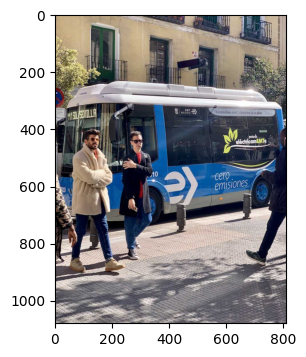

pre process time = 12.13 ms
input_tensor.shape = (884736,)


In [6]:
# 读取一张bgr8格式的图像, 并进行可视化
begin_time = time()
img = cv2.imread("../../../resource/assets/bus.jpg")
print("\033[1;31m" + f"cv2.imread time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
print(f"{img.shape = }")
jshow(img)

# 利用resize的方式进行前处理, 准备nv12的输入数据
# 注: 如果在yaml文件中配置为nchw-rgb输入, 可使用OpenCV和numpy准备输入数据
begin_time = time()
input_tensor = cv2.resize(img, (model_h, model_w), interpolation=cv2.INTER_NEAREST) # 利用resize重新开辟内存节约一次
# input_tensor = cv2.cvtColor(input_tensor, cv2.COLOR_BGR2RGB)
# # input_tensor = np.array(input_tensor) / 255.0  # yaml文件中已经配置前处理
# input_tensor = np.transpose(input_tensor, (2, 0, 1))
# input_tensor = np.expand_dims(input_tensor, axis=0).astype(np.uint8)  # NCHW

input_tensor = bgr2nv12_opencv(input_tensor)
print("\033[1;31m" + f"pre process time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
print(f"{input_tensor.shape = }")

img_h, img_w = img.shape[0:2]
y_scale, x_scale = img_h/model_h, img_w/model_w

In [7]:
# 推理
begin_time = time()
quantize_outputs = quantize_model[0].forward(input_tensor)
print("\033[1;31m" + f"forward time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

forward time = 17.78 ms


In [8]:
# c to np
begin_time = time()
clses = [quantize_outputs[trans[i]].buffer for i in range(nl)]
bboxes = [quantize_outputs[trans[i + 5]].buffer for i in range(nl)]
centers = [quantize_outputs[trans[i + 10]].buffer for i in range(nl)]
print("\033[1;31m" + f"c to numpy time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

for stride, cls, bbox, center in zip(strides, clses, bboxes, centers):
    print(f"{stride}: {cls.shape = }  {bbox.shape = }  {center.shape = }")

c to numpy time = 5.33 ms
8: cls.shape = (1, 96, 96, 80)  bbox.shape = (1, 96, 96, 4)  center.shape = (1, 96, 96, 1)
16: cls.shape = (1, 48, 48, 80)  bbox.shape = (1, 48, 48, 4)  center.shape = (1, 48, 48, 1)
32: cls.shape = (1, 24, 24, 80)  bbox.shape = (1, 24, 24, 4)  center.shape = (1, 24, 24, 1)
64: cls.shape = (1, 12, 12, 80)  bbox.shape = (1, 12, 12, 4)  center.shape = (1, 12, 12, 1)
128: cls.shape = (1, 6, 6, 80)  bbox.shape = (1, 6, 6, 4)  center.shape = (1, 6, 6, 1)


In [9]:
# reshape
begin_time = time()
clses = [clses[i].reshape(-1, nc) for i in range(nl)]
bboxes = [bboxes[i].reshape(-1, 4) for i in range(nl)]
centers = [centers[i].reshape(-1, 1) for i in range(nl)]
print("\033[1;31m" + f"reshape time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

for stride, cls, bbox, center in zip(strides, clses, bboxes, centers):
    print(f"stride {stride}: {cls.shape = }  {bbox.shape = }  {center.shape = }")

reshape time = 1.30 ms
stride 8: cls.shape = (9216, 80)  bbox.shape = (9216, 4)  center.shape = (9216, 1)
stride 16: cls.shape = (2304, 80)  bbox.shape = (2304, 4)  center.shape = (2304, 1)
stride 32: cls.shape = (576, 80)  bbox.shape = (576, 4)  center.shape = (576, 1)
stride 64: cls.shape = (144, 80)  bbox.shape = (144, 4)  center.shape = (144, 1)
stride 128: cls.shape = (36, 80)  bbox.shape = (36, 4)  center.shape = (36, 1)


In [10]:
# classify: 利用numpy向量化操作完成阈值筛选 (优化版 2.0)
begin_time = time()
scores, ids, indices = [], [], []
for cls, center, clses_scale, centers_scale in zip(clses, centers, clses_scales, centers_scales):
    cls = cls if clses_scale is None else cls.astype(np.float32)*clses_scale
    center = center if centers_scale is None else center.astype(np.float32)*centers_scale
    raw_max_scores = np.max(cls, axis=1)
    max_scores = np.sqrt(1 / ((1 + np.exp(-center[:,0]))*(1 + np.exp(-raw_max_scores))))
    valid_indices = np.flatnonzero(max_scores >= conf)
    ids.append(np.argmax(cls[valid_indices, :], axis=1))
    scores.append(max_scores[valid_indices])
    indices.append(valid_indices)
print("\033[1;31m" + f"Conf Threshold time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
for stride, score, id_, indic in zip(strides, scores, ids, indices):
    print(f"stride {stride}: {score.shape=}  {id_.shape=}  {indic.shape=}")

Conf Threshold time = 16.94 ms
stride 8: score.shape=(1,)  id_.shape=(1,)  indic.shape=(1,)
stride 16: score.shape=(11,)  id_.shape=(11,)  indic.shape=(11,)
stride 32: score.shape=(18,)  id_.shape=(18,)  indic.shape=(18,)
stride 64: score.shape=(10,)  id_.shape=(10,)  indic.shape=(10,)
stride 128: score.shape=(0,)  id_.shape=(0,)  indic.shape=(0,)


In [11]:
# 特征解码 (筛选计算版)
begin_time = time()
xyxys = []
for indic, grid, stride, bbox, bboxes_scale in zip(indices, grids, strides, bboxes, bboxes_scales):
    grid_indices = grid[indic, :]
    bbox = bbox[indic, :] if bboxes_scale is None else bbox[indic, :].astype(np.float32)*bboxes_scale
    bbox = bbox*stride if is_stride else bbox
    x1y1 = grid_indices - bbox[:, 0:2]
    x2y2 = grid_indices + bbox[:, 2:4]
    xyxys.append(np.hstack([x1y1, x2y2]))
print("\033[1;31m" + f"decode time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

decode time = 2.62 ms


In [12]:
# 大中小特征层阈值筛选结果拼接
begin_time = time()
xyxy = np.concatenate([_ for _ in xyxys], axis=0)
scores = np.concatenate([_ for _ in scores], axis=0)
ids = np.concatenate([_ for _ in ids], axis=0)
print("\033[1;31m" + f"concat time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{xyxy.shape = }  {scores.shape = }  {ids.shape = }")

concat time = 1.45 ms
xyxy.shape = (40, 4)  scores.shape = (40,)  ids.shape = (40,)


In [13]:
# nms
begin_time = time()
indices = cv2.dnn.NMSBoxes(xyxy, scores, conf, iou)
print("\033[1;31m" + f"nms time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{len(indices) = }")

nms time = 0.64 ms
len(indices) = 6


In [14]:
# 整理
bboxes = (xyxy[indices] * np.array([x_scale, y_scale, x_scale, y_scale])).astype(np.int32)
scores = scores[indices]
ids = ids[indices]

In [15]:
# 绘制
draw_img = img.copy()
begin_time = time()
for class_id, score, bbox in zip(ids, scores, bboxes):
    x1, y1, x2, y2 = bbox
    print("(%d, %d, %d, %d) -> %s: %.2f"%(x1,y1,x2,y2, coco_names[class_id], score))
    draw_detection(draw_img, (x1, y1, x2, y2), score, class_id)

print("\033[1;31m" + f"Draw Result time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

(51, 390, 244, 905) -> person: 0.85
(224, 401, 344, 866) -> person: 0.79
(7, 225, 801, 737) -> bus: 0.67
(669, 398, 808, 883) -> person: 0.63
(137, 473, 151, 514) -> tie: 0.56
(0, 554, 77, 874) -> person: 0.50
Draw Result time = 4.99 ms


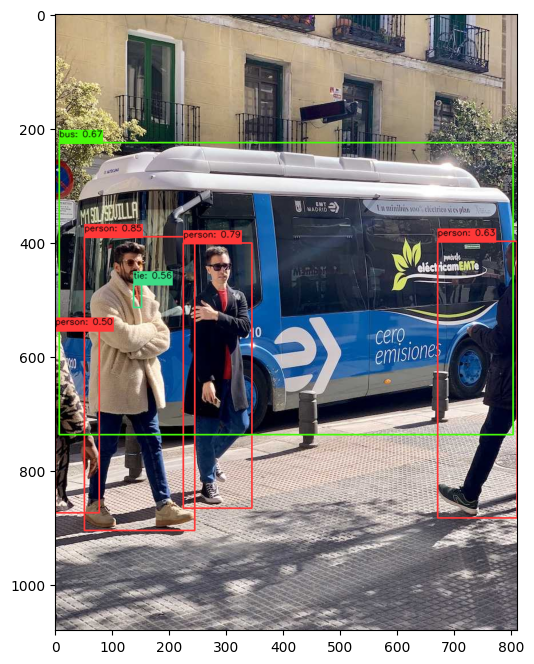

In [16]:
jshow(draw_img, 8)